# 06.02 - PCA

In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/ai4eng.v1/main/content/init.py
import init; init.init(force_download=False); init.get_weblink()

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


consulta [A Tutorial on Principal Component Analysis](https://www.cs.princeton.edu/picasso/mats/PCA-Tutorial-Intuition_jp.pdf) para una decripción intuitiva y detallada de PCA y SVD

## Intuición

tenemos los siguientes datos 2D y nos gustaría encontrar una proyección en 1D que preserve la máxima cantidad de variabilidad.


(200, 2)


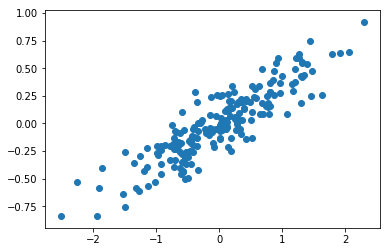

In [3]:
np.random.seed(1)
X = np.dot(np.random.random(size=(2, 2)), np.random.normal(size=(2, 200))).T+10

# center data on 0,0
X=X-np.mean(X, axis=0)
print (X.shape)
plt.scatter(X[:,0], X[:,1])

recuerda que la proyección de un vector $\vec{x}$ en otro vector $\vec{v}$ (consulta [here](https://matthew-brett.github.io/teaching/vector_projection.html)) viene dada por:

$$c = \frac{\vec{v}\times \vec{x}}{||\vec{v}||^2}$$


$$proj_\vec{v} \vec{x} = \vec{v} c$$


donde $c$ es el tamaño de la proyección de  $\vec{x}$ sobre $\vec{v}$

### inspeccionamos algunas proyecciones

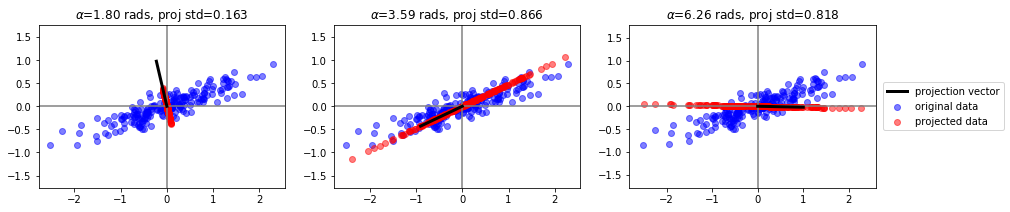

In [4]:
plt.figure(figsize=(15,3))

unit_vector = lambda angle: np.array([np.cos(angle), np.sin(angle)])

for i in range(3):
    plt.subplot(1,3,i+1)
    angle = np.random.random()*np.pi*2 if i!=0 else 1.8
    v = unit_vector(angle)

    c = X.dot(v.reshape(-1,1))/(np.linalg.norm(v)**2)
    Xp = np.repeat(v.reshape(-1,2),len(X),axis=0)*c

    plt.scatter(X[:,0], X[:,1], color="blue", alpha=.5, label="original data")
    plt.scatter(Xp[:,0], Xp[:,1], color="red", alpha=.5, label="projected data")
    plt.axvline(0, color="gray")
    plt.axhline(0, color="gray")
    plt.plot([0,v[0]], [0,v[1]], color="black", lw=3, label="projection vector")
    plt.axis('equal')
    plt.ylim(-2,2)
    plt.title("$\\alpha$=%.2f rads, proj std=%.3f"%(angle, np.std(c)))
    if i==2:
        plt.legend(loc="center left", bbox_to_anchor=(1.01,.5))

### encontremos las proyecciones con mayor y menor std por fuerza bruta

Text(0,0.5,'projection std')

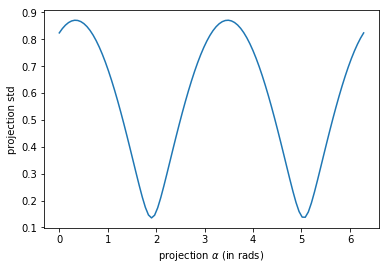

In [5]:
def get_maxmin_projections(X):
    stds = []
    angles = np.linspace(0,np.pi*2, 100)
    for a in angles:
        v = np.array([np.cos(a), np.sin(a)])
        c = X.dot(v.reshape(-1,1))/(np.linalg.norm(v)**2)
        stds.append(np.std(c))
    v2 = unit_vector(angles[np.argmin(stds)])
    v1 = unit_vector(angles[np.argmax(stds)])
    
    return angles, stds, v1, v2
angles, stds, v1, v2 = get_maxmin_projections(X)

plt.plot(angles, stds)
plt.xlabel("projection $\\alpha$ (in rads)")
plt.ylabel("projection std")

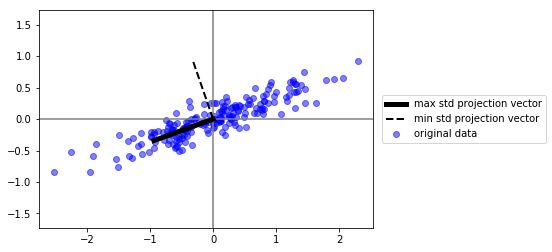

In [6]:
plt.scatter(X[:,0], X[:,1], color="blue", alpha=.5, label="original data")
plt.axvline(0, color="gray")
plt.axhline(0, color="gray")
plt.plot([0,v1[0]], [0,v1[1]], color="black", lw=5, label="max std projection vector")
plt.plot([0,v2[0]], [0,v2[1]], color="black", ls="--", lw=2, label="min std projection vector")
plt.axis('equal')
plt.ylim(-2,2)
plt.legend(loc="center left", bbox_to_anchor=(1.01,.5))

**estos son los componentes principales**!! **observa que su dimensionalidad es la misma que los datos originales**

esto es lo que PCA nos da

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1) 
pca.fit(X)
print ("sklearn PCA components")
print (pca.components_)
print ("brute force components")
print (v1)
print (v2)

sklearn PCA components
[[-0.94446029 -0.32862557]]
brute force components
[-0.93969262 -0.34202014]
[-0.32706796  0.94500082]


In [10]:
c = pca.transform(X)
print (c.shape)
c

(200, 1)


array([[ 6.76769235e-01],
       [-1.07121393e+00],
       [ 7.27912364e-01],
       [ 2.30964136e+00],
       [ 6.30052323e-01],
       [ 1.02448887e+00],
       [ 7.77183507e-01],
       [-1.39656414e+00],
       [-2.91049874e-01],
       [ 1.88864221e+00],
       [-7.11544293e-01],
       [ 6.38884130e-01],
       [ 5.48059617e-01],
       [-2.19312436e-01],
       [-3.87789490e-01],
       [ 7.15219956e-01],
       [-1.08373816e+00],
       [-2.99917403e-01],
       [-7.96849021e-01],
       [-8.12568346e-01],
       [-1.54018281e+00],
       [-2.52920476e-01],
       [ 6.26464454e-01],
       [-1.61007571e+00],
       [ 5.04240563e-01],
       [ 5.53935753e-01],
       [ 6.81911252e-01],
       [-2.00157228e-02],
       [ 1.13550833e-01],
       [ 2.92286085e-02],
       [-2.14393483e-01],
       [-1.03406124e+00],
       [ 3.88635004e-01],
       [ 9.96727811e-01],
       [ 1.39223653e+00],
       [ 4.57043694e-01],
       [ 6.81839901e-01],
       [-9.05233246e-01],
       [ 4.9

pero de modo mucho más eficiente

In [11]:
%timeit pca.fit(X)

144 µs ± 2.69 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [12]:
%timeit get_maxmin_projections(X)

3.1 ms ± 62.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### we can use the largest component to reduce our data from 2D to 1D
### podemos usar el componente mayor para reducir la dimensionalidad de nuestros datos de 2D a 1D

observa que:

$$\mathbf{X_t} = \mathbf{X} \times \mathbf{V}$$

donde:
- $\mathbf{X}$ son nuestros datos
- $\mathbf{V}$ es el vector de componentes seleccionados
- $\mathbf{X_t}$ son los datos transformados

así que nos estamos restringiendo a **transformaciones linealer** (rotaciones y escalado)


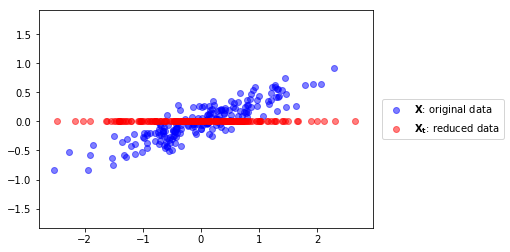

In [13]:
pca = PCA(n_components=1)
pca.fit(X)
Xt = pca.transform(X)[:,0]
plt.scatter(X[:,0], X[:,1], color="blue", alpha=.5, label="$\mathbf{X}$: original data")
plt.scatter(Xt, [0]*len(Xt), color="red", alpha=.5, label="$\mathbf{X_t}$: reduced data")
plt.axis("equal");
plt.legend(loc="center left", bbox_to_anchor=(1.01,.5))

y podemos también recontruir los datos 2D después de la transformación

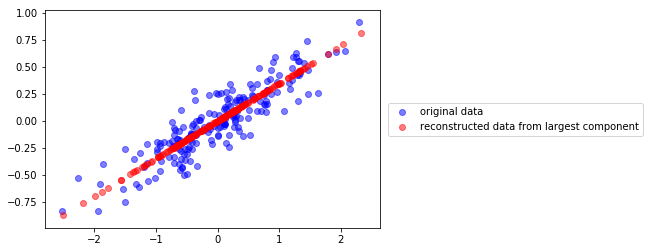

In [14]:
v0 = pca.components_[0]
c = X.dot(v0)
Xr = np.r_[[i*v0 for i in c]]
plt.scatter(X[:,0], X[:,1], color="blue", alpha=.5, label="original data")
plt.scatter(Xr[:,0], Xr[:,1], color="red", alpha=.5, label="reconstructed data from largest component")
plt.legend(loc="center left", bbox_to_anchor=(1.01,.5))